# Solving the Poisson equation for Newtonian Potential in 3D

The Newtonian gravitational potential $\Phi(x)$ of a uniform density sphere in 3 dimensions satisfies, again, the equation 
$$-\Delta\Phi(x) = \rho(x)\quad x\in S^d_R,\quad d=3.$$

Here, $S^d_R$ is the sphere of radius $R$ in dimension $d$, and $\rho(x)$ is the mass density, taken to be constant, $\rho(x) = \rho_0$. 

Like the 2D problem, the problem in 3 dimensions has an analytic solution [See Cohl and Palmer, *Fourier and Gegenbauer Expansions for a Fundamental Solution of Laplace's Equation in Hyperspherical Geometry*] 

In particular, for uniform density $\rho = \rho_0>0$, and radius $R = r_0>0$, the exact solution is

$$ \Phi(x) :=\cases{-\frac{\rho_0}{6}\big(3r_0^2 - r^2\big),\quad r\in[0,r_0], \\
\frac{\rho_0 r_0^3}{3r},\quad r\in(r_0,\infty).}$$

This formula says that $\Phi(r_0)=\frac{\rho_0 r_0^2}{3}$ on the boundary. We use this as the boundary data for our numerical solver. 

Here is the code which solves the boundary value problem and visualizes the solution.

In [1]:
########################################################################################################
################################## MESHING #############################################################
########################################################################################################
import dolfinx
from mpi4py import MPI
#mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

import gmsh
gmsh.initialize()

sphere = gmsh.model.occ.addSphere(0, 0, 0, 1)
#gmsh.model.occ.addCurveLoop([ellipse], 5)
#membrane = gmsh.model.occ.addPlaneSurface([5])
gmsh.model.occ.synchronize()

gdim = 3
gmsh.model.addPhysicalGroup(gdim, [sphere], 1)

gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.1)
gmsh.model.mesh.generate(gdim)

from dolfinx.io import gmshio

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

gmsh.write("mesh3D.msh")


domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=3)

########################################################################################################
################################## DEFINE EXACT SOLUTION ###############################################
########################################################################################################
from dolfinx import fem, mesh, fem, io, nls, log
import ufl
import numpy
from petsc4py.PETSc import ScalarType

#define the values of mass density, radius, and log of radius, and create constant functions on 
#the mesh for these values
rho0_0 = 12 #Mass density
R0_0 = 1.0 #Radius of disc
lnR0_0 = numpy.log(R0_0) #log of disc radius

x = ufl.SpatialCoordinate(domain)
rho0 = fem.Constant(domain, ScalarType(rho0_0))
R0 = fem.Constant(domain, ScalarType(R0_0)) 
lnR0 = fem.Constant(domain, ScalarType(lnR0_0))

#p is the exact analytic solution
p = (rho0 / 6) * (3 * R0**2 - (x[0]**2 + x[1]**2 + x[2]**2))

########################################################################################################
################################## DEFINE BOUNDARY CONDITION ###########################################
########################################################################################################
#note that u_ufl is the same function as p, but is specified using, e.g., R0_0 instead of R0
u_ufl = (rho0_0 / 6) * (3 * R0_0**2 - (x[0]**2 + x[1]**2 + x[2]**2))
V = fem.FunctionSpace(domain, ("CG", 1))
u_exact = lambda x: eval(str(u_ufl))
u_D = fem.Function(V)
u_D.interpolate(u_exact)
fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, lambda x: numpy.full(x.shape[1], True, dtype=bool))

bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets))

########################################################################################################
################################## ALTERNATIVE SPECIFICATION OF BOUNDARY DATA ##########################
########################################################################################################
#import numpy as np
#def on_boundary(x):
#    return np.isclose(np.sqrt((x[0])**2 + x[1]**2), 1) #must be changed accordingly for elliptic boundary
#boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)

#bc = fem.dirichletbc(p, boundary_dofs, V)

########################################################################################################
################################## SET UP AND SOLVE VARIATIONAL PROBLEM ################################
########################################################################################################
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = rho0 * v * ufl.dx
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

########################################################################################################
u_err = fem.Function(V)
u_err = abs(u_D - uh)
########################################################################################################

########################################################################################################
################################## PLOT SOLUTION USING PYVISTA #########################################
########################################################################################################
from dolfinx.plot import create_vtk_mesh
import pyvista
pyvista.set_jupyter_backend("pythreejs")

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

# Set deflection values and add it to plotter
grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=.25)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, style = 'points', point_size = 25, show_edges = True, opacity = .5)

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    plotter.screenshot("deflection.png")    
    
    
#import dolfinx.io
#u_D.name = "Exact Solution"
#uh.name = "Numerical Solution"
#with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "Poisson_solution1.xdmf", "w") as xdmf:
#    xdmf.write_mesh(domain)
#    xdmf.write_function(u_D)
#    xdmf.write_function(uh)
    
with dolfinx.io.VTKFile(MPI.COMM_WORLD, "Poisson_solution.pvd", "w") as vtk:

    vtk.write_mesh(domain)
    vtk.write_function([uh._cpp_object])
    
    #vtk.write([uh._cpp_object])
    #vtk.write_mesh(domain)
#    vtk.write_function(u_D)
    #vtk.write_function(uh)

Info    : Meshing 1D...
Info    : [ 40%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.0013378s, CPU 0.000793s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Sphere, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0965375s, CPU 0.091608s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 1578 nodes...
Info    : Done tetrahedrizing 1586 nodes (Wall 0.0216179s, CPU 0.015148s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.0452804s, CPU 0.037066s)
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 10.7044 (nodes removed 0 0)
Info    : It. 500 - 500 nodes created - worst tet radius 1.60862 (nodes removed 0 0)
Info    : It. 1000 - 1000 nodes created - worst tet radius 1.31171 (nodes removed 0 0)
Info    : It. 1500 - 1500 nodes created - worst tet radi

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

Plot the mesh (Note: when using 'wireframe' mode, only the outer surface of the mesh will be rendered).

In [2]:
########################################################################################################
################################## PLOT SOLUTION USING PYVISTA #########################################
########################################################################################################
from dolfinx.plot import create_vtk_mesh
import pyvista
pyvista.set_jupyter_backend("pythreejs")

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

# Set deflection values and add it to plotter
grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=.125)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, style = "wireframe", color = 'y')
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    plotter.screenshot("deflection.png")

2022-12-19 13:30:48.021 (   8.286s) [        AE1E6740]    vtkExtractEdges.cxx:435   INFO| Executing edge extractor: points are renumbered
2022-12-19 13:30:48.025 (   8.290s) [        AE1E6740]    vtkExtractEdges.cxx:551   INFO| Created 4728 edges


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

Compute the (normalized) $L^\infty$ error between the computed solution and the known exact solution

In [4]:
import ufl
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx.fem import (Expression, Function, FunctionSpace,
                         assemble_scalar, dirichletbc, form, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_unit_square, locate_entities_boundary
from ufl import SpatialCoordinate, TestFunction, TrialFunction, div, dot, dx, grad, inner

def error_infinity(u_h, u_ex):
    # Interpolate exact solution, special handling if exact solution
    # is a ufl expression or a python lambda function
    comm = u_h.function_space.mesh.comm
    u_ex_V = Function(u_h.function_space)
    if isinstance(u_ex, ufl.core.expr.Expr):
        u_expr = Expression(u_ex, u_h.function_space.element.interpolation_points)
        u_ex_V.interpolate(u_expr)
    else:
        u_ex_V.interpolate(u_ex)
    # Compute infinity norm, furst local to process, then gather the max
    # value over all processes
    error_max_local = np.max(np.abs((u_h.x.array-u_ex_V.x.array)/u_ex_V.x.array))
    error_max = comm.allreduce(error_max_local, op=MPI.MAX)
    return error_max

In [6]:
error_infinity(uh, u_exact)

0.001961798312527939

The following is a plot of the (normalized) error along the y axis

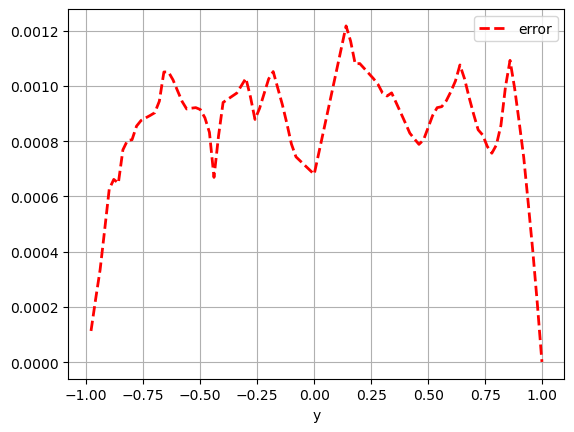

In [7]:
tol = 0.001 # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = np.zeros((3, 101))
points[1] = y
u_values = []  #this will be uh
p_values = []  #this will be u_exact

from dolfinx import geometry
bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)


cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
        
        
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)
p_values = u_D.eval(points_on_proc, cells)


import matplotlib.pyplot as plt
fig = plt.figure()
#plt.plot(points_on_proc[:,1], u_values, "k", linewidth=2, label="numerical solution")
#plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth = 2, label="exact solution")
plt.plot(points_on_proc[:, 1], abs(p_values - u_values)/u_values, "r--", linewidth = 2, label="error")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")

The absolute error abs(u_D-uh) restricted to the positive y axis

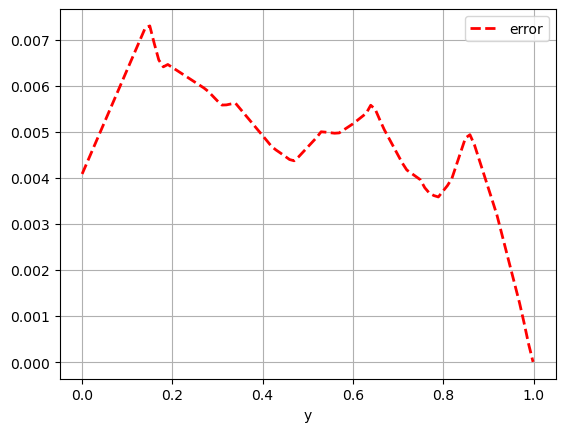

In [6]:
tol = 0.001 # Avoid hitting the outside of the domain
y = np.linspace(0, 1 - tol, 101)
points = np.zeros((3, 101))
points[1] = y
u_values = []  #this will be uh
p_values = []  #this will be u_exact

from dolfinx import geometry
bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)


cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
        
        
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)
p_values = u_D.eval(points_on_proc, cells)


import matplotlib.pyplot as plt
fig = plt.figure()
#plt.plot(points_on_proc[:,1], u_values, "k", linewidth=2, label="numerical solution")
#plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth = 2, label="exact solution")
plt.plot(points_on_proc[:, 1], abs(p_values - u_values), "r--", linewidth = 2, label="error")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")

In [16]:
len(uh.x.array)

3999

In [26]:
grid.points

pyvista_ndarray([[ 0.79163737, -0.31868823, -0.52129462],
                 [ 0.73084927, -0.32972416, -0.59761302],
                 [ 0.74446194, -0.40031115, -0.53434764],
                 ...,
                 [-0.6206632 ,  0.44132563,  0.64808092],
                 [-0.54480758,  0.49648728,  0.67578479],
                 [-0.56113268,  0.40905473,  0.71958623]])

In [28]:
len(grid.points)

3999

In [10]:
topology
len(topology)

98865

In [12]:
cell_types
len(cell_types)

19773

In [14]:
x
len(x)

3999

In [41]:
numpy.linalg.norm(grid.points, axis=0)

array([30.85818276, 30.83683691, 30.85819319])

In [53]:
Radius = numpy.linalg.norm(grid.points, axis=1)
len(Radius)

3999

In [34]:
grid.point_data["u_err"]

pyvista_ndarray([0., 0., 0., ..., 0., 0., 0.])

In [57]:
len(grid.point_data["u_err"])

3999

In [24]:
grid

UnstructuredGrid (0x7ff173a27160)
  N Cells:	19773
  N Points:	3999
  X Bounds:	-9.993e-01, 1.000e+00
  Y Bounds:	-9.984e-01, 9.998e-01
  Z Bounds:	-1.000e+00, 1.000e+00
  N Arrays:	1

Here is the absolute error plotted for all nodes

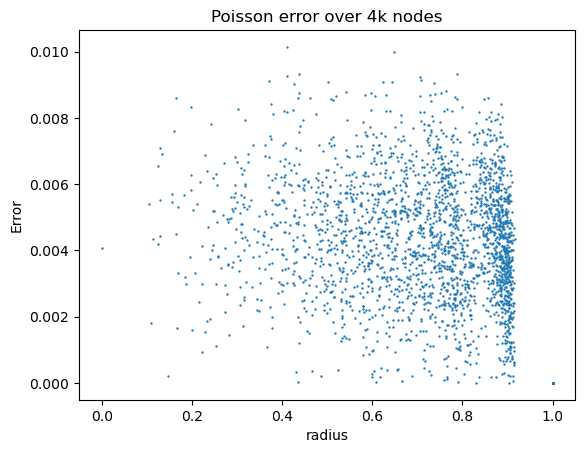

In [71]:
import numpy as np
import matplotlib.pyplot as plt

y = grid.point_data["u_err"]

plt.scatter(Radius, y, s = .5, marker = 'o')
plt.ylabel('Error')
plt.xlabel('radius')
plt.title('Poisson error over 4k nodes')
plt.savefig('PoissonError.png')
plt.show()

Is there a way to evaluate the error inside each cell, and then plot this as a scatter plot (as above)?

This would have the benefit of increasing the number of points (from 3999 to 19773) and potentially 
fix the gaps at the tails of the distribution. Should be able to change the .point_data to .cell_data in the working code below...

Normalized error plotted over the Nodes

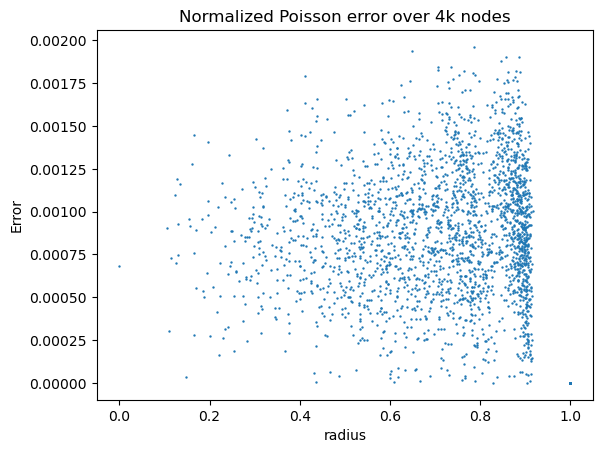

In [20]:
from dolfinx.plot import create_vtk_mesh
import pyvista
pyvista.set_jupyter_backend("pythreejs")

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)


# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

# Set deflection values and add it to plotter
grid.point_data["u_err"] = abs(uh.x.array - u_D.x.array)/u_D.x.array


Radius = numpy.linalg.norm(grid.points, axis=1)


import numpy as np
import matplotlib.pyplot as plt

y = grid.point_data["u_err"]

plt.scatter(Radius, y, s = .5, marker = 'o')
plt.ylabel('Error')
plt.xlabel('radius')
plt.title('Normalized Poisson error over 4k nodes')
plt.savefig('PoissonError.png')
plt.show()


In [12]:
mesh = pyvista.PolyData(x, topology)
centers = mesh.cell_centers()

In [13]:
centers

PolyData,Information
N Cells,19773
N Points,19773
N Strips,0
X Bounds,"-9.713e-01, 9.726e-01"
Y Bounds,"-9.739e-01, 9.730e-01"
Z Bounds,"-9.748e-01, 9.741e-01"
N Arrays,0


In [13]:
grid = centers.cast_to_unstructured_grid()

In [14]:
grid

UnstructuredGrid,Information
N Cells,19773
N Points,19773
X Bounds,"-9.713e-01, 9.726e-01"
Y Bounds,"-9.739e-01, 9.730e-01"
Z Bounds,"-9.748e-01, 9.741e-01"
N Arrays,0


if centers can be put in array form, then plotting should be as simple as it was above!

In [20]:
centers.points

pyvista_ndarray([[ 0.7446218 , -0.34602492, -0.52517471],
                 [ 0.76209981, -0.36047084, -0.48995853],
                 [ 0.41581714, -0.62571454, -0.60916103],
                 ...,
                 [-0.5683938 ,  0.47006434,  0.6384765 ],
                 [-0.52494041,  0.44594467,  0.69138144],
                 [-0.55844519,  0.440447  ,  0.66824708]])

In [6]:
len(centers.points)

19773

In [51]:
centers.cell_data

pyvista DataSetAttributes
Association     : CELL
Active Scalars  : None
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays : None

It is wrong to put cell_types in as the second argument below, but it is apparently the correct format of input...

In [14]:
UH = uh.eval(centers.points, numpy.arange(len(cell_types)))

In [20]:
len(UH)

19773

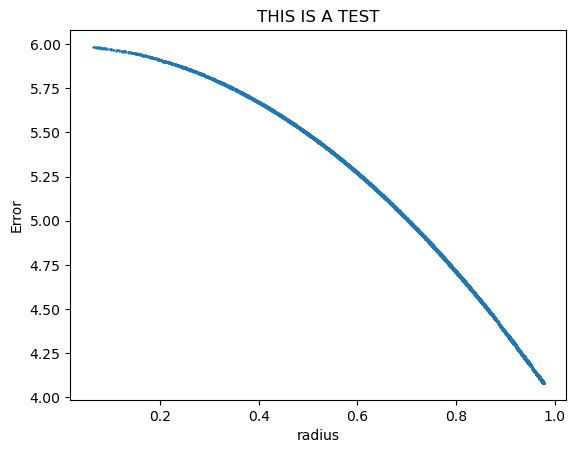

In [15]:
Radius = numpy.linalg.norm(centers.points, axis=1)


import numpy as np
import matplotlib.pyplot as plt


plt.scatter(Radius, UH, s = .5, marker = 'o')
plt.ylabel('Error')
plt.xlabel('radius')
plt.title('THIS IS A TEST')
plt.savefig('NOTError.png')
plt.show()

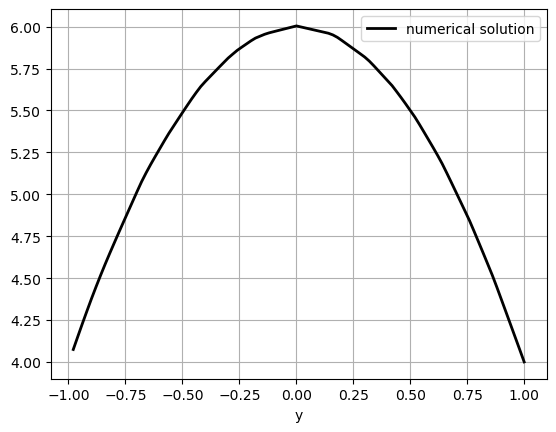

In [16]:
tol = 0.001 # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = np.zeros((3, 101))
points[1] = y
u_values = []  #this will be uh
p_values = []  #this will be u_exact

from dolfinx import geometry
bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)


cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
        
        
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)
p_values = u_D.eval(points_on_proc, cells)


import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(points_on_proc[:,1], u_values, "k", linewidth=2, label="numerical solution")
#plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth = 2, label="exact solution")
#plt.plot(points_on_proc[:, 1], abs(p_values - u_values), "r--", linewidth = 2, label="error")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")

In [17]:
UD = u_D.eval(centers.points, numpy.arange(len(cell_types)))

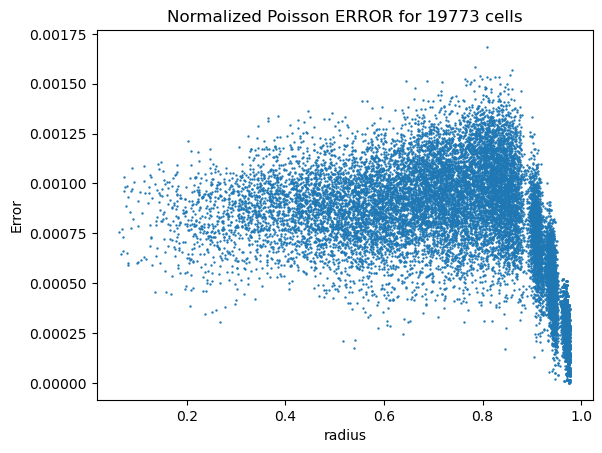

In [19]:
Radius = numpy.linalg.norm(centers.points, axis=1)


import numpy as np
import matplotlib.pyplot as plt


plt.scatter(Radius, abs(UH - UD)/UD, s = .5, marker = 'o')

plt.ylabel('Error')
plt.xlabel('radius')
plt.title('Normalized Poisson ERROR for 19773 cells')
plt.savefig('CELLError.png')
plt.show()